In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station 

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

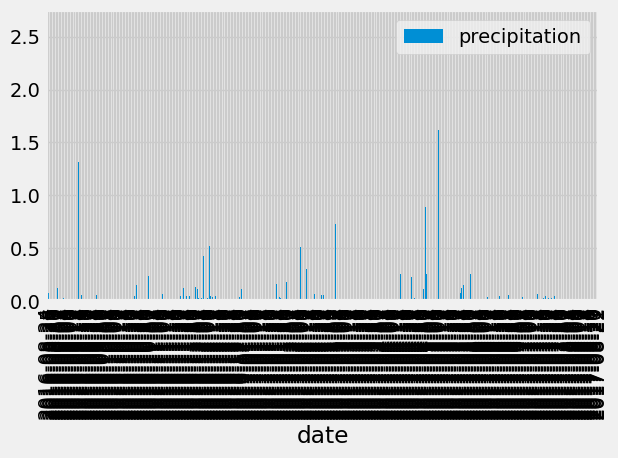

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
data_query = session.query(Measurement.prcp, Measurement.date)\
    .filter(Measurement.date > '2016-08-23')\
    .filter(Measurement.date < '2017-08-23')\
    .group_by(Measurement.date)\
    .order_by(Measurement.date)\
    .all()
data_query

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data_query, columns=['precipitation', 'date'])

# Sort the dataframe by date
df_sorted = df.sort_values(by='date').dropna()

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted = pd.DataFrame(data_query, columns=['precipitation', 'date'])
df_sorted.set_index('date', inplace=True)
df_sorted.plot.bar()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Calculate summary statistics using describe()
summary_stats = df_sorted.describe()
summary_stats

,precipitation
count,362.000000
mean,0.048978
std,0.205465
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.id, Station.name).all()
total_stations

[(1, 'WAIKIKI 717.2, HI US'),
 (2, 'KANEOHE 838.1, HI US'),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'PEARL CITY, HI US'),
 (5, 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'WAIHEE 837.5, HI US'),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'MANOA LYON ARBO 785.2, HI US')]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

for station in active_stations:
    print(station.station, station.observation_count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Query to calculate lowest, highest, and average temperature for the most active station
result = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == 'USC00519281') \
    .first()

lowest_temp, highest_temp, avg_temp = result

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


<function matplotlib.pyplot.show(close=None, block=None)>

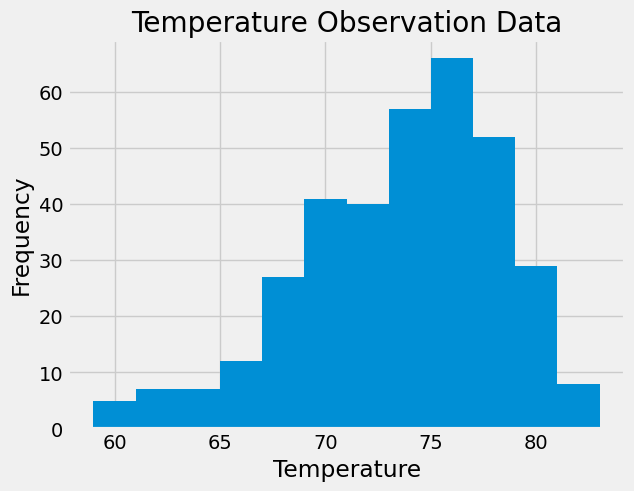

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(func.max(Measurement.date)).scalar()
start_date = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date >= start_date)\
    .all()

tobs_values = [result[0] for result in tobs_data]
plt.hist(tobs_values, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data')
plt.show

# Close Session

In [16]:
# Close Session
session.close()